In [27]:
import pandas as pd

gendered_news = pd.read_json("~/Desktop/gendered-news.json")


In [28]:
gendered_news

,id,title,gender,text,lang
0,chalmers-sv-00050,Internettjänst förbättrar vården för nyfödda o...,K,Internettjänst förbättrar vården för nyfödda o...,sv
1,chalmers-sv-00055,Nya tekniker ger störst klimatnytta i massaind...,K,Nya tekniker ger störst klimatnytta i massaind...,sv
2,chalmers-sv-00056,Karin Markides rektor i ytterligare tre år,K,NAMN Markides rektor i ytterligare tre år Chal...,sv
3,chalmers-sv-00070,Unik forskning på Googles inre liv,K,Unik forskning på Googles inre liv Google är e...,sv
4,chalmers-sv-00076,Vartannat sjöbefäl somnar vid rodret,K,Vartannat sjöbefäl somnar vid rodret PRESSMEDD...,sv
...,...,...,...,...,...
4963,sodertorn-sv-00061,Prins Daniels Fellowship till Södertörns högskola,M,Prins NAMN Fellowship till Södertörns högskola...,sv
4964,sodertorn-sv-00062,Södertörns högskola och Fryshuset inleder sama...,M,Södertörns högskola och Fryshuset inleder sama...,sv
4965,sodertorn-sv-00066,Sten Heckscher utses till hedersdoktor vid Söd...,M,NAMN Heckscher utses till hedersdoktor vid Söd...,sv
4966,sodertorn-sv-00074,Entreprenör blir Årets alumn vid Södertörns hö...,M,Entreprenör blir Årets alumn vid Södertörns hö...,sv


In [29]:

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test =  train_test_split(range(len(gendered_news)), gendered_news['gender'], test_size=0.25, random_state=42)

In [30]:
gendered_news['isTestSplit'] = [False for x in range(len(gendered_news))]

In [32]:
for i,row in gendered_news.iterrows() :
    if i in Y_train : 
        gendered_news.loc[i,'isTestSplit'] = True


In [33]:
gendered_news['isTestSplit'].value_counts()

True     3726
False    1242
Name: isTestSplit, dtype: int64

In [34]:
# Save splits for future use
gendered_news.to_csv("gendered_news.csv")

In [35]:
def to_int(gender) :
    if gender == 'K' : 0
    else : 1

In [40]:
X_train = gendered_news[gendered_news['isTestSplit'] == False]
X_test  = gendered_news[gendered_news['isTestSplit'] == True]

In [38]:
# Create tagged documents for training a doc2vec model
import gensim
train_corpus = []

for idx, row in (X_train.iterrows()) :
    words = [ w for w in row['text'].split()] 
    train_corpus.append(gensim.models.doc2vec.TaggedDocument(words, [to_int(row['gender'])]))
    
test_corpus = []
for idx, row in (X_test.iterrows()) :
    words = [ w for w in row['text'].split()]
    test_corpus.append(gensim.models.doc2vec.TaggedDocument(words, [to_int(row['gender'])]))


In [43]:
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec

vector_size = 300
SEED = 64

# Build Doc2Vec - DM

model_dm = gensim.models.doc2vec.Doc2Vec(
    dm=1,
    dm_mean=1,
    window=8,
    vector_size=vector_size,
    min_count=2,
    epochs=10,
    seed=SEED
)
model_dm.build_vocab(train_corpus)
model_dm.train(train_corpus, total_examples=model_dm.corpus_count, epochs=model_dm.epochs)

# Build Doc2Vec - DBOW

model_dbow = gensim.models.doc2vec.Doc2Vec(
    dm=0,
    negative=5,
    hs=0,
    sample=0,
    vector_size=vector_size,
    min_count=2,
    epochs=10,
    seed=SEED
)
model_dbow.build_vocab(train_corpus)
model_dbow.train(train_corpus, total_examples=model_dbow.corpus_count, epochs=model_dbow.epochs)

# Concatenate
model = ConcatenatedDoc2Vec([model_dm, model_dbow])

In [45]:
# Create Train/Test Data.
import numpy as np

X_train_ = []
y_train_ = []

for idx, row in (X_train.iterrows()):
    y_train_.append(row['gender'])
    words = [ w for w in row['text'].split()] 
    X_train_.append(model.infer_vector(words, steps=20))

X_test_ = []
y_test_ = []

for idx, row in (X_test.iterrows()) :
    y_test_.append(row['gender'])
    words = [ w for w in row['text'].split()] 
    X_test_.append(model.infer_vector(words, steps=20))
    
X_train = np.array(X_train_)
y_train = np.array(y_train_)
X_test = np.array(X_test_)
y_test = np.array(y_test_)
    
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1242, 600)
(1242,)
(3726, 600)
(3726,)


In [46]:
# Train a logistic regression model on the inferred doc2vec vectors of the training data
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression(
            penalty='elasticnet',
            solver='saga',
            fit_intercept=True,
            class_weight='balanced',
            random_state=SEED,
            l1_ratio=0.5
        )

logmodel.fit(X_train, y_train)

/opt/anaconda3/envs/idp/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(class_weight='balanced', l1_ratio=0.5, penalty='elasticnet',
                   random_state=64, solver='saga')

In [47]:
y_pred = logmodel.predict(X_test)

In [50]:
# Accuracy scores of doc2vec/logistic regression model on the test data

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['K', 'M']))

              precision    recall  f1-score   support

           K       0.65      0.60      0.62      1807
           M       0.65      0.69      0.67      1919

    accuracy                           0.65      3726
   macro avg       0.65      0.64      0.64      3726
weighted avg       0.65      0.65      0.65      3726



In [56]:
from sklearn.decomposition import PCA

pca_test = PCA(n_components=2)


pca_test.fit(X_train)

    
pca_transformed_test = pca_test.transform(X_train)


No handles with labels found to put in legend.


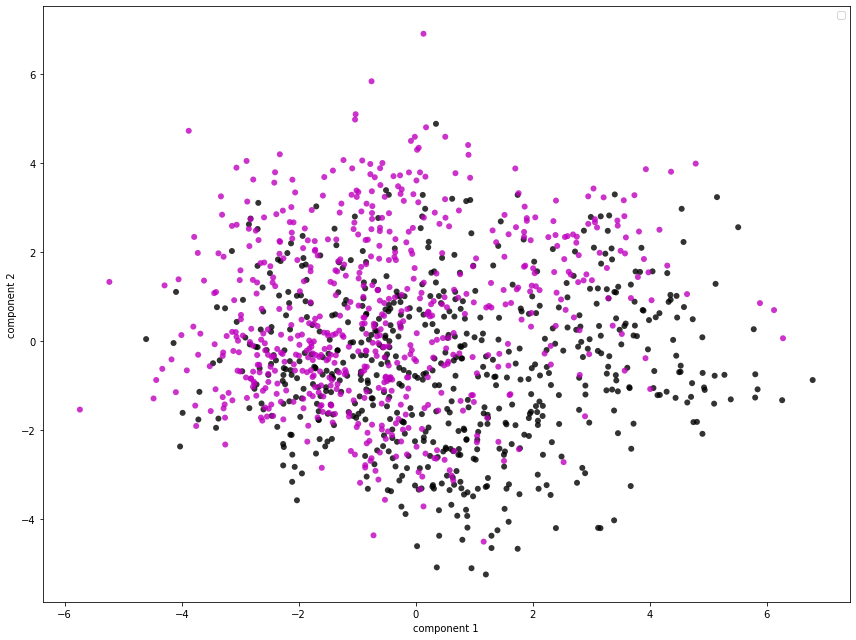

In [59]:
# Plots the two first principal components of the doc2vec representations of the training data

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,9))

scatter = plt.scatter(pca_transformed_test[:, 0], pca_transformed_test[:, 1],
c=y_train, edgecolor='none', alpha=0.8,
cmap=plt.cm.get_cmap('rainbow', 2))
plt.xlabel('component 1')
plt.ylabel('component 2')

plt.legend(handles=scatter.legend_elements()[0], labels=['K','M'])


plt.tight_layout()
plt.show()

In [65]:
## Create training and test data for a bag-of-words TFIDF/Logistic regression model

train_corpus = []

i = 0
for idx, row in (gendered_news[gendered_news['isTestSplit'] == False].iterrows()) : 
    words = ["".join([c.lower() for c in w if c.isalpha() or c in ['-']]) for w in row['text'].split()]
    train_corpus.append(words)
    

In [66]:
test_corpus = []


for idx, row in (gendered_news[gendered_news['isTestSplit'] == True].iterrows()) : 
    words = ["".join([c.lower() for c in w if c.isalpha() or c in ['-']]) for w in row['text'].split()]
    test_corpus.append(words)


In [238]:
from collections import Counter
vocab = Counter()

for doc in train_corpus : 
    vocab.update(doc)

print(len(vocab))

print(vocab.most_common(50))

min_occurence=1
frequent_tokens = [k for k,c in vocab.items() if c >= min_occurence and len(k) > 1]  



48611
[('', 81318), ('och', 21403), ('i', 17036), ('att', 16503), ('som', 11752), ('namn', 11102), ('av', 10342), ('för', 10091), ('en', 9621), ('är', 8957), ('det', 8889), ('på', 8851), ('med', 7163), ('har', 6311), ('till', 6242), ('de', 5928), ('den', 5007), ('ett', 4684), ('om', 4635), ('kan', 3516), ('vid', 3484), ('säger', 2708), ('från', 2671), ('universitet', 2653), ('inte', 2646), ('hen', 2372), ('phone', 2347), ('vi', 2331), ('hur', 2153), ('men', 2053), ('sig', 2007), ('mer', 1881), ('email', 1747), ('eller', 1720), ('göteborgs', 1711), ('så', 1611), ('man', 1611), ('också', 1596), ('var', 1473), ('olika', 1467), ('under', 1432), ('när', 1390), ('-', 1368), ('finns', 1366), ('inom', 1358), ('visar', 1322), ('forskning', 1284), ('där', 1265), ('sin', 1230), ('andra', 1212)]


In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

vectorizer.fit([" ".join(text) for text in train_corpus]) 

TfidfVectorizer()

In [ ]:
Xtrain_tfidf = vectorizer.transform([" ".join(text) for text in train_corpus])

In [72]:
Xtest_tfidf = vectorizer.transform([" ".join(text) for text in test_corpus])

In [83]:
len(vectorizer.get_feature_names())

In [86]:
import multiprocessing

num_cores = multiprocessing.cpu_count()

In [87]:
from sklearn.linear_model import LogisticRegression
log_model_tfidf = LogisticRegression(penalty='l1',max_iter=1000,solver='saga',n_jobs=num_cores)

LogisticRegression(max_iter=1000, n_jobs=4, penalty='l1', solver='saga')

In [88]:
y_pred = log_model_tfidf.predict(Xtest_tfidf)

In [89]:
print(classification_report(y_test, y_pred, target_names=['K','M']))

              precision    recall  f1-score   support

           K       0.63      0.54      0.58      1807
           M       0.62      0.71      0.66      1919

    accuracy                           0.63      3726
   macro avg       0.63      0.62      0.62      3726
weighted avg       0.63      0.63      0.62      3726



In [93]:
Xtrain_tfidf[0]

<1x47415 sparse matrix of type '<class 'numpy.float64'>'
	with 367 stored elements in Compressed Sparse Row format>

In [253]:
voc = vectorizer.get_feature_names()
most_important_k = [ (voc[i],coef) for i,coef in enumerate(log_model_tfidf.coef_[0]) if coef < -0.1]
most_important_m = [ (voc[i],coef) for i,coef in enumerate(log_model_tfidf.coef_[0]) if coef > 0.1]

In [213]:
print(most_important_k)
print(most_important_m)

[('arbete', -0.29889933530585694), ('att', -0.8111815053484652), ('avhandling', -9.214452106893862), ('barn', -2.962471231570489), ('barnen', -0.22437533497392803), ('de', -0.4865574050145069), ('det', -0.2856244023858482), ('eleverna', -0.808121192864023), ('kvinnor', -5.337216226848547), ('kvinnors', -0.24721785105666283), ('om', -2.388914083758841), ('unesco', -0.9812050547921836)]
[('forskarna', 0.3595039123230342), ('iv', 0.45415327628471724), ('lunds', 4.155391091344121), ('nu', 0.20407809680150063), ('professor', 5.014087967403347)]


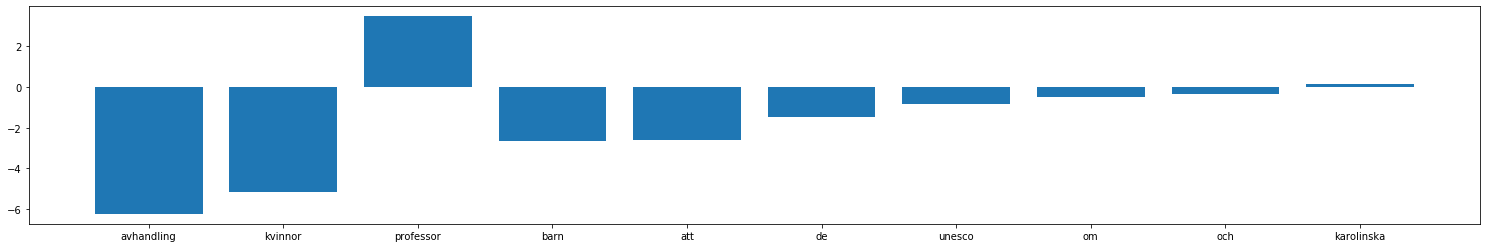

In [246]:
import matplotlib.pyplot as plt

def plotImportance(importance_1,importance_2) : 
    sorted_1 = sorted(importance_1 + importance_2,key = lambda x : abs(x[1]), reverse=True)

    y_pos = [i for (i,v) in sorted_1] 
    columns = [v for (i,v) in sorted_1]
    plt.figure(figsize=(26,4))
    plt.bar(y_pos, columns, width=0.8)
    plt.xticks(y_pos, y_pos,)
    plt.show()
    
plotImportance(most_important_k,most_important_m)


In [229]:
unis = set([val.split('-')[0] for val in gendered_news['id'].values])

In [256]:
# Get the important features of a model trained on all universities except the one listed
# (or if "leave_in" parameter is True: get the important features of a model trained on the university listed)

def leave_out_or_in_uni(uni,leave_in) :
    print(uni)
    if leave_in : 
        gendered_news_modified = gendered_news[gendered_news['id'].str.startswith(uni)]
    else : gendered_news_modified = gendered_news[~gendered_news['id'].str.startswith(uni)]
    print(len(gendered_news_modified))
    trainsplit = gendered_news_modified[gendered_news_modified['isTestSplit'] == False]
    testsplit  = gendered_news_modified[gendered_news_modified['isTestSplit'] == True]
    Y_train_modified = trainsplit['gender']
    Y_test_modified  = testsplit['gender']
    

    train_corpus_modified = []
 
    for idx, row in (trainsplit.iterrows()) :
        words = ["".join([c.lower() for c in w if c.isalpha() or c in ['-']]) for w in row['text'].split()]
        train_corpus_modified.append(words)
    
        test_corpus_modified = []

    for idx, row in (testsplit.iterrows()) : 

        words = ["".join([c.lower() for c in w if c.isalpha() or c in ['-']]) for w in row['text'].split()]
 
        test_corpus_modified.append(words)

    vectorizer = TfidfVectorizer()
    vectorizer.fit([" ".join(text) for text in train_corpus_modified]) 
    Xtrain_tfidf_modified = vectorizer.transform([" ".join(text) for text in train_corpus_modified])
    Xtest_tfidf_modified = vectorizer.transform([" ".join(text) for text in test_corpus_modified])
    
    log_model_tfidf_modified = LogisticRegression(penalty='l1',max_iter=1000,solver='saga',n_jobs=num_cores) 
    log_model_tfidf_modified.fit(Xtrain_tfidf_modified,Y_train_modified)
    
    voc = vectorizer.get_feature_names()
    most_important_k = [ (voc[i],coef) for i,coef in enumerate(log_model_tfidf_modified.coef_[0]) if coef < -0.1]
    most_important_m = [ (voc[i],coef) for i,coef in enumerate(log_model_tfidf_modified.coef_[0]) if coef > 0.1]
    plotImportance(most_important_k,most_important_m)

malardalen


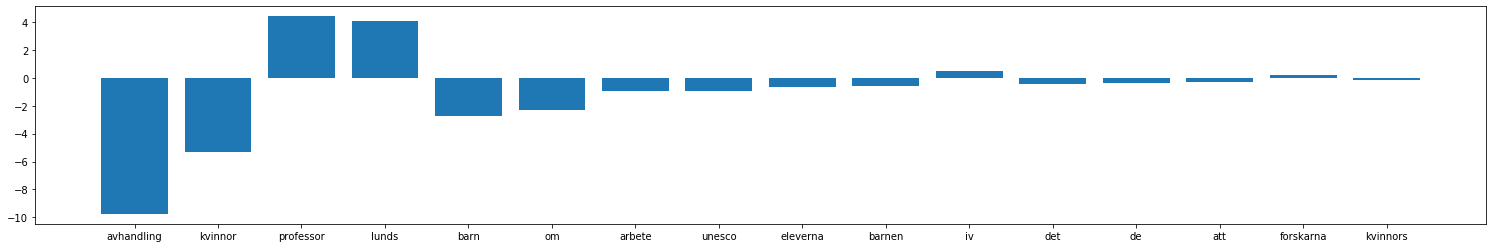

mittuni


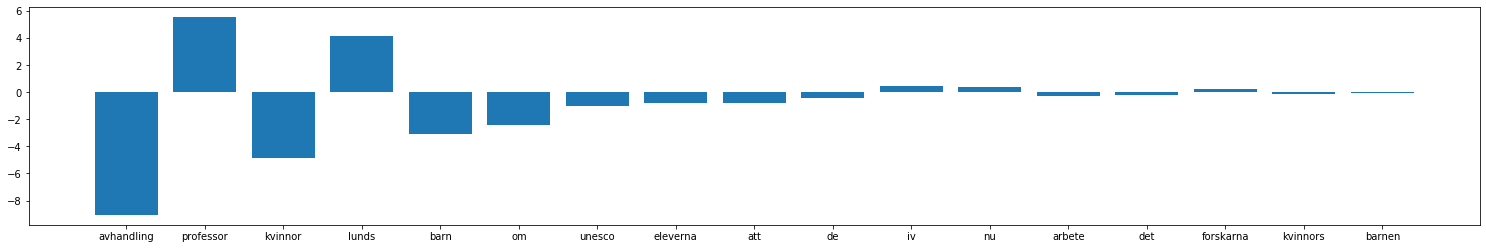

rise


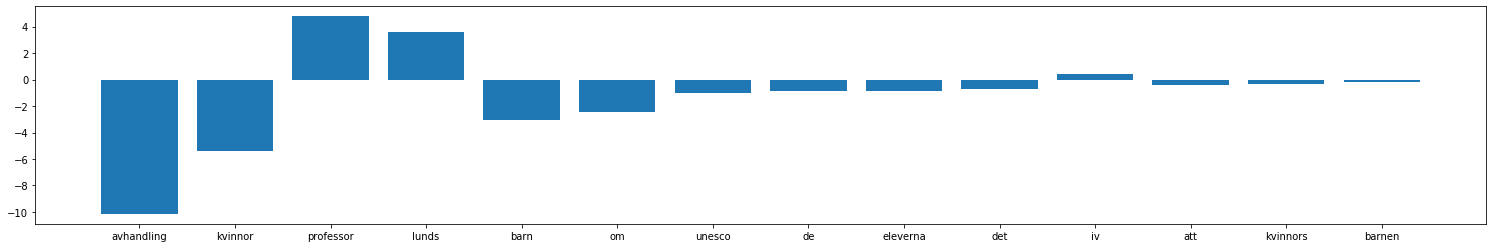

chalmers


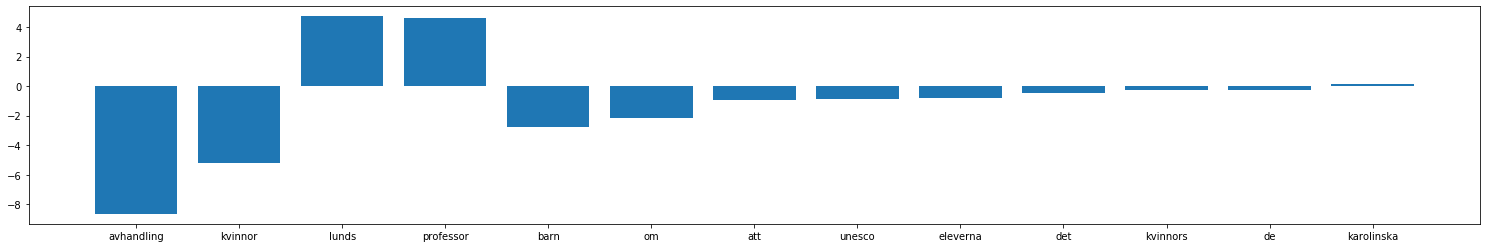

dalarna


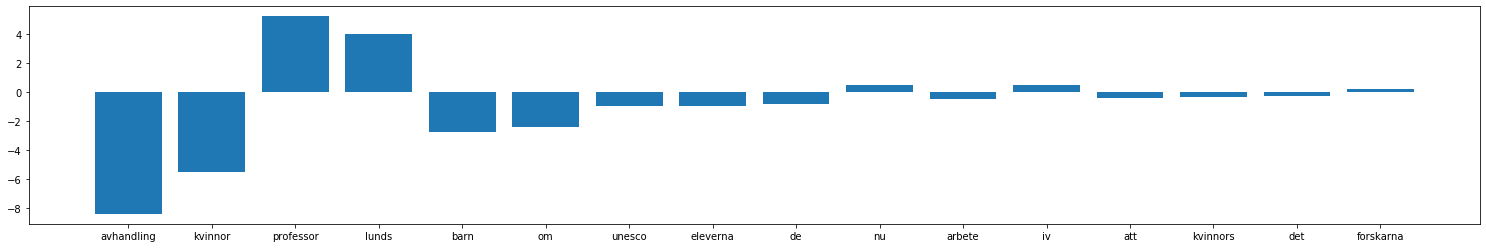

sodertorn


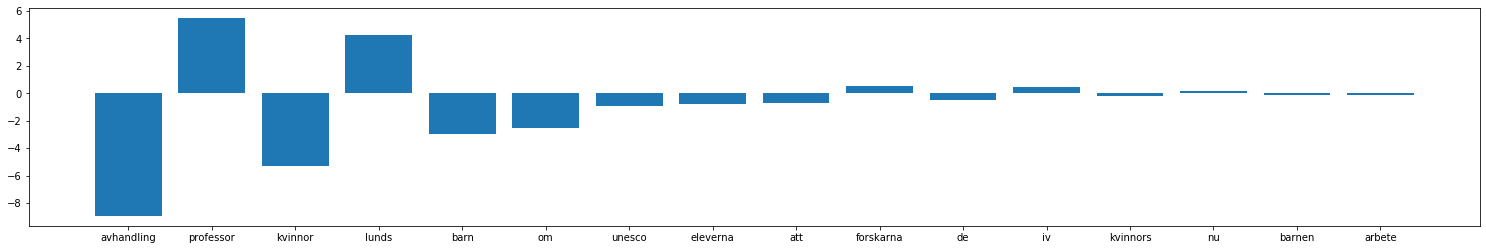

malmo


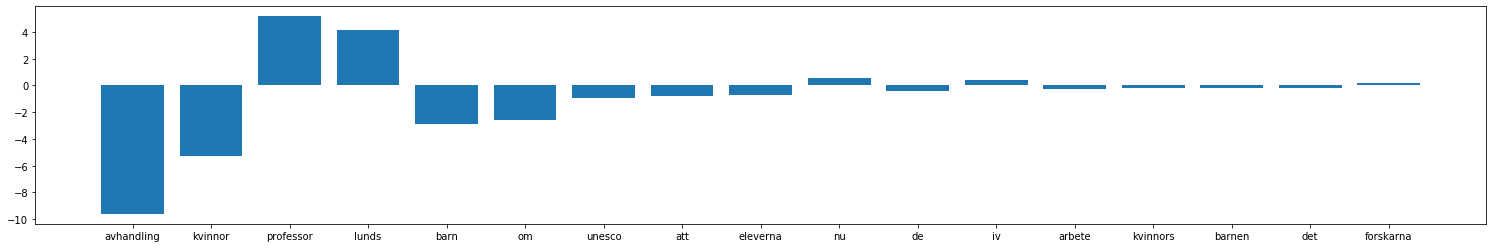

kva


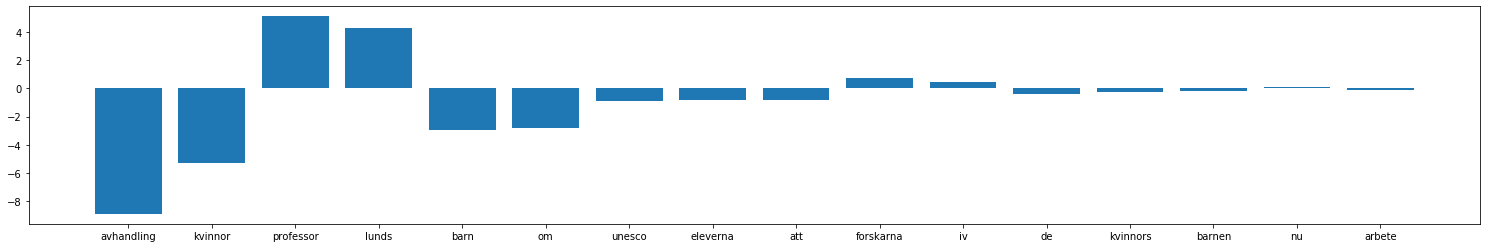

ki


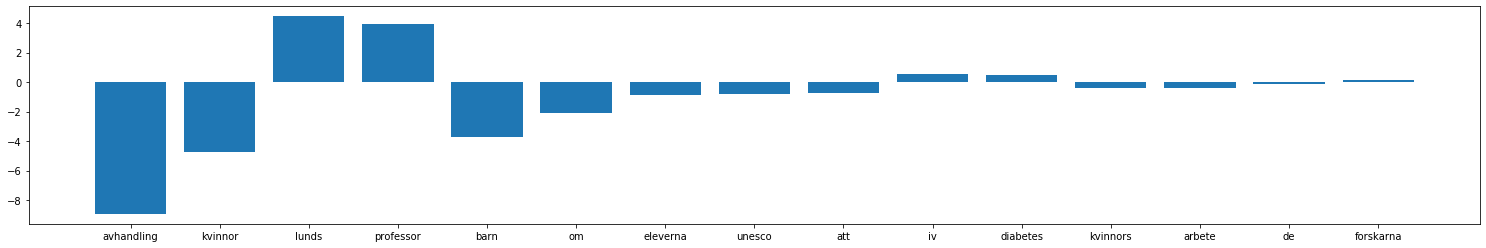

handels


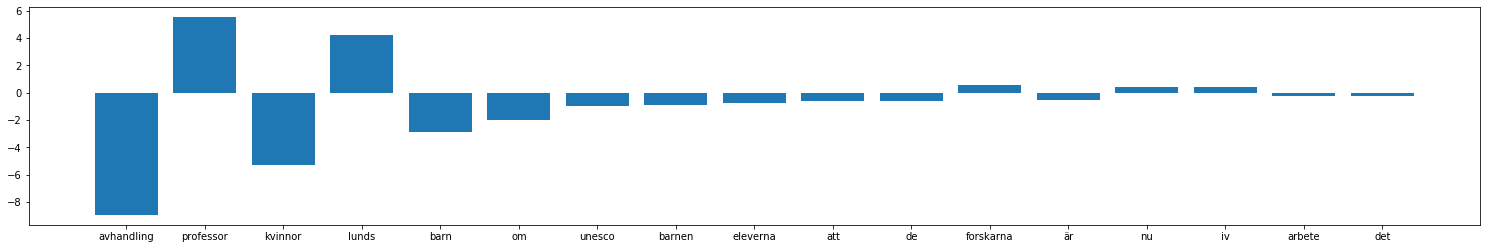

sahlgrenska


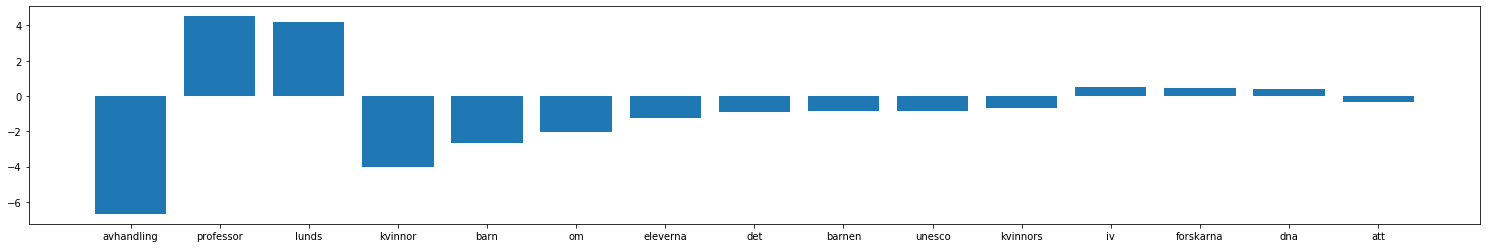

liu


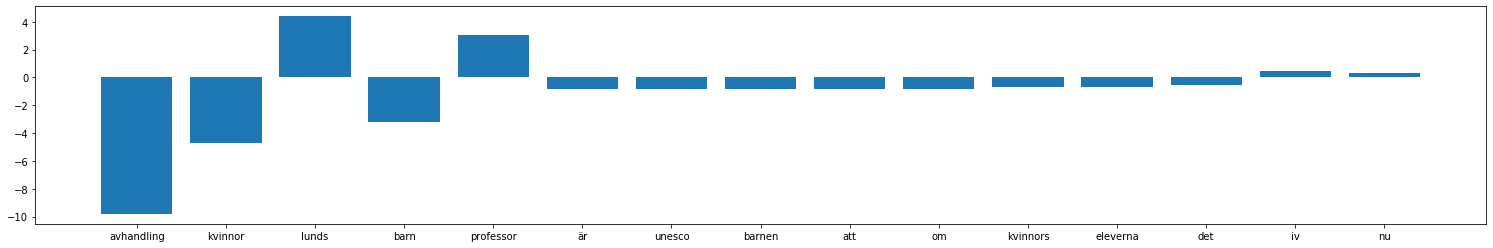

lu2


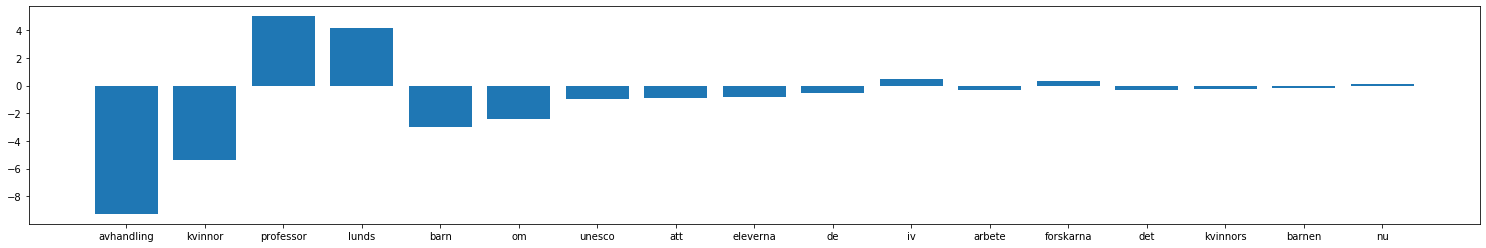

gu


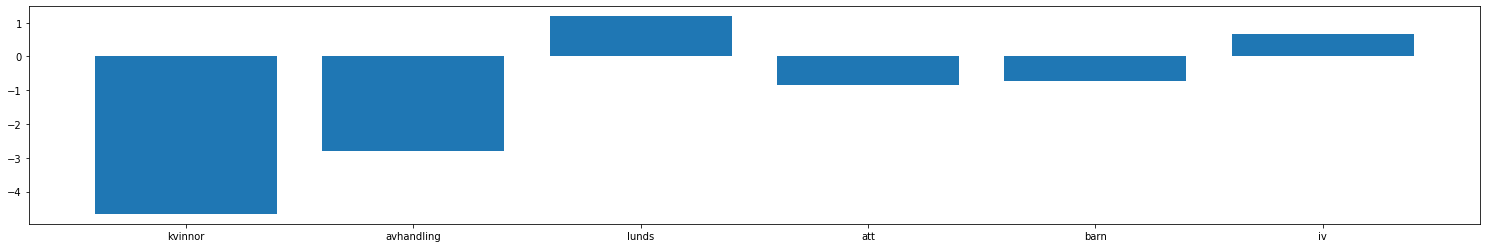

kmh


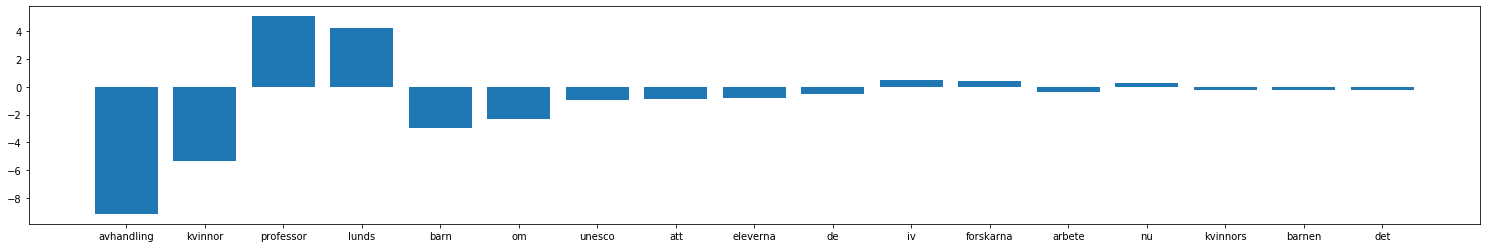

lu


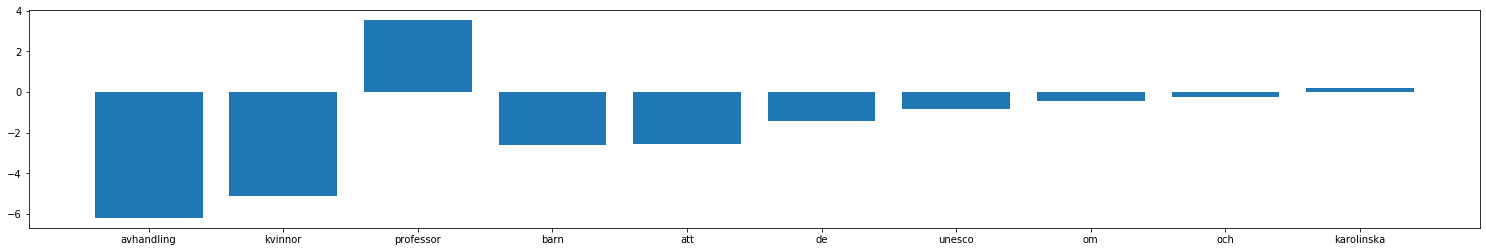

In [250]:
for uni in unis:
    leave_out_or_in_uni(uni,False)

malardalen
101


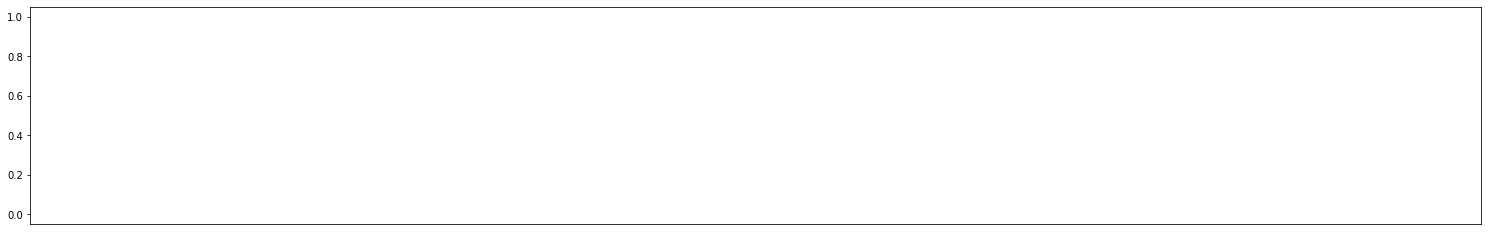

mittuni
111


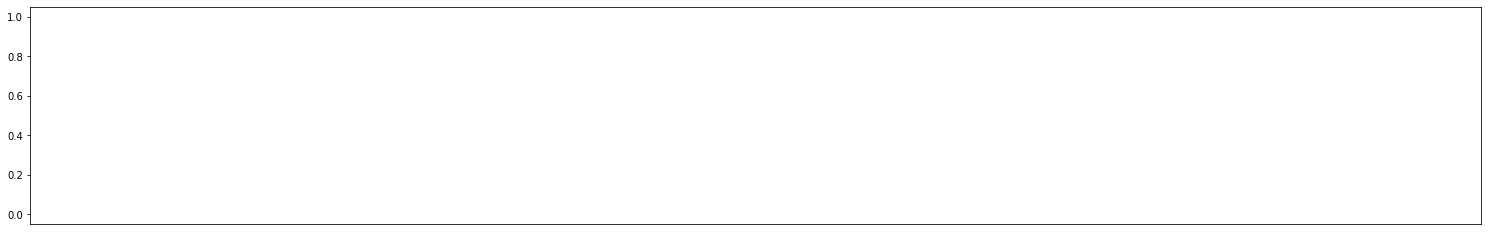

rise
203


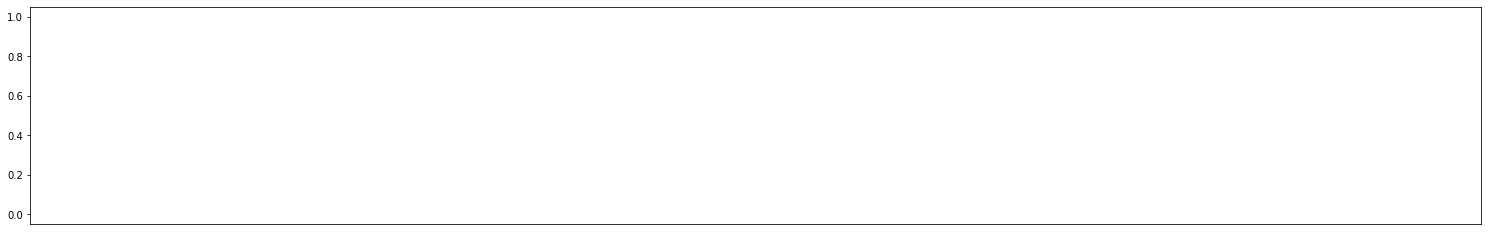

chalmers
179


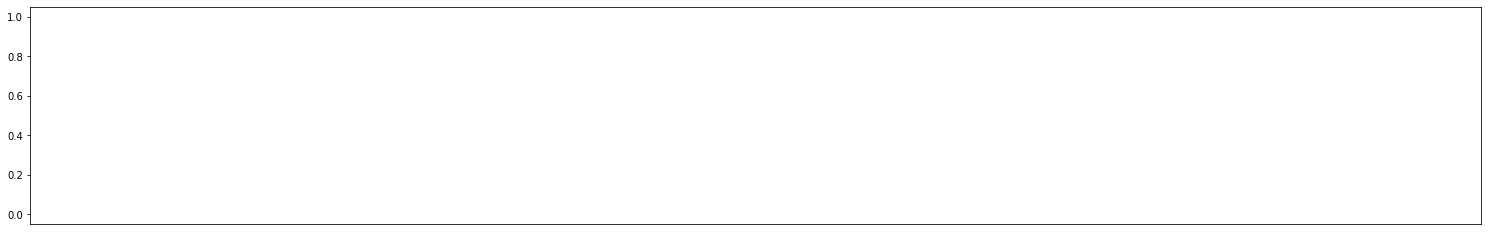

dalarna
73


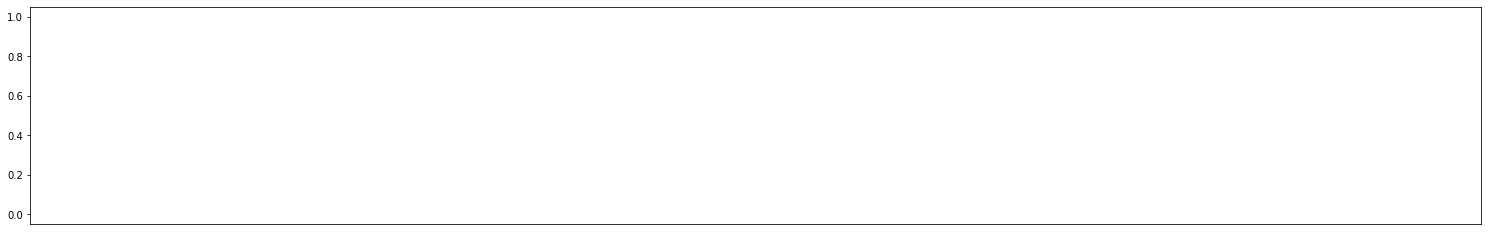

sodertorn
32


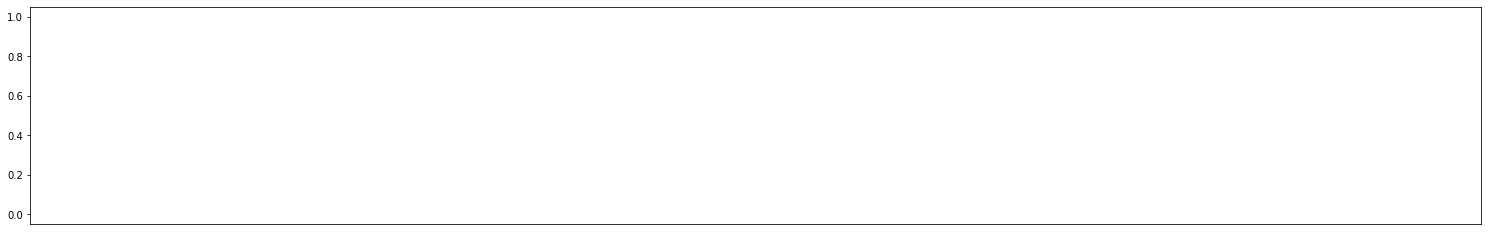

malmo
45


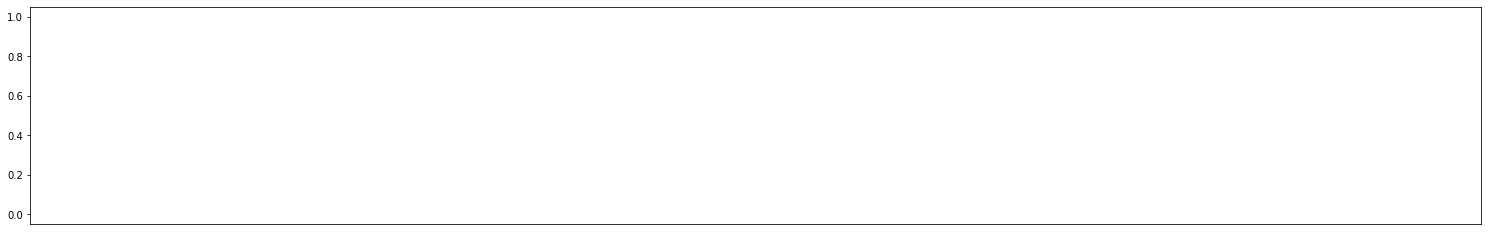

kva
48


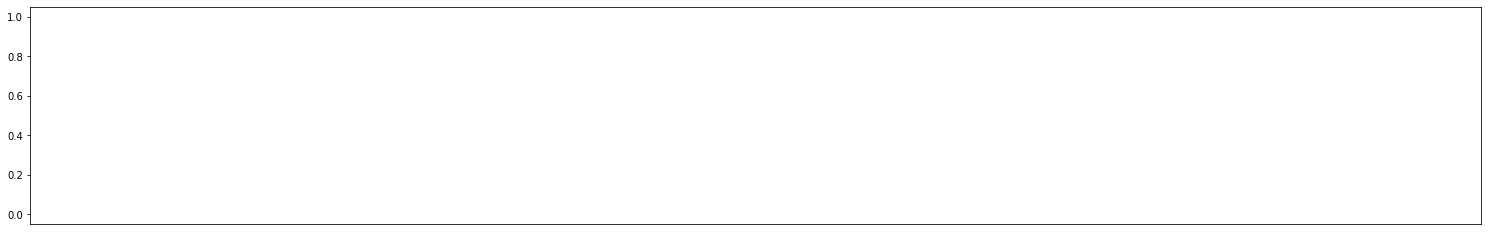

ki
213


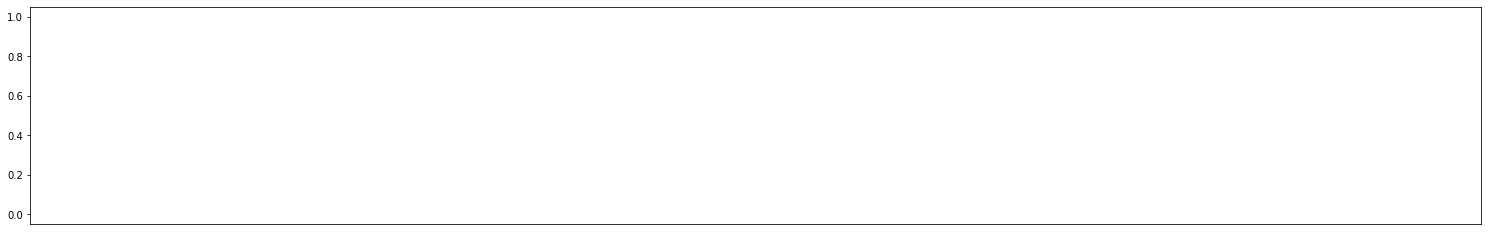

handels
91


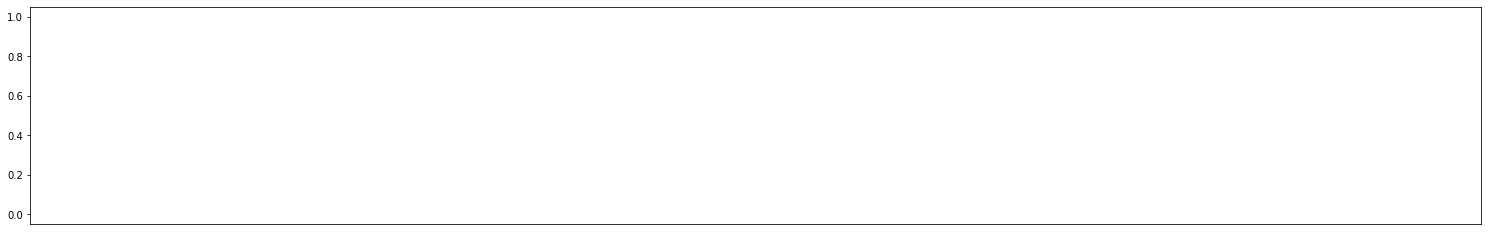

sahlgrenska
332


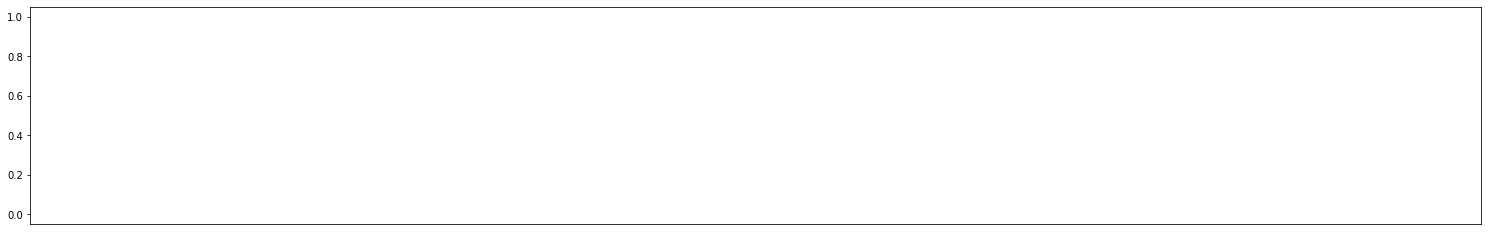

liu
350


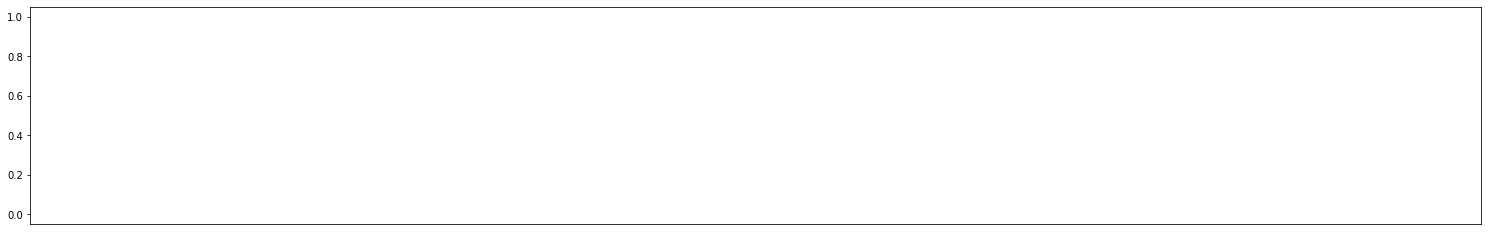

gu
2370


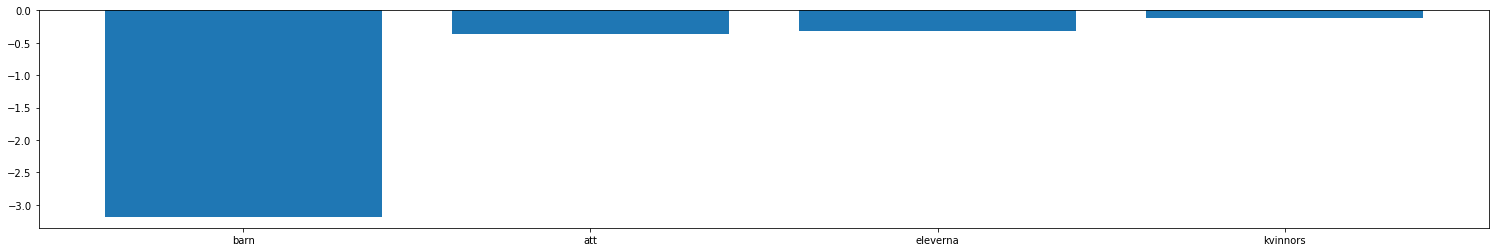

lu
818


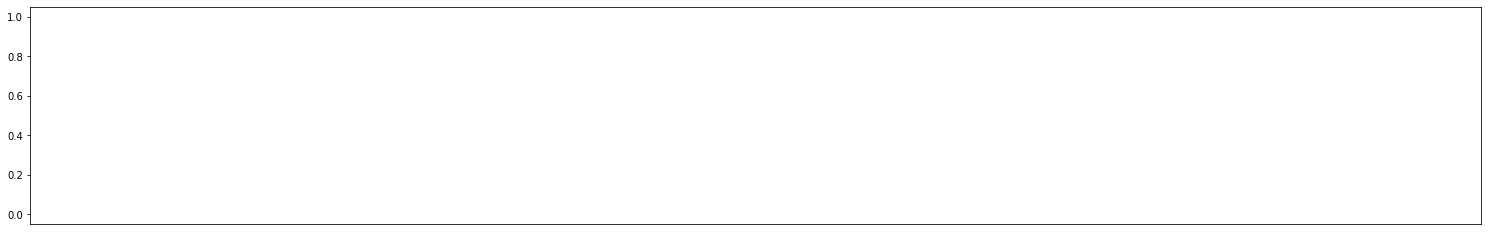

In [259]:
for uni in unis:
    if not uni in ['lu2','kmh'] : 
        leave_out_or_in_uni(uni,True)